# MovingBoundaryHeatExchanger (and SectionedHeatExchanger) class

- 3 different categories of HeatExchangers

1. 0D models without secondary side
   - energy balance only, no pinch information
   - SimpleHeatExchanger
   - (ParabolicTrough, SolarCollector, Pipe)
2. 0D models with secondary side (no internal states know)
   - HeatExchanger
   - Desuperheater (x=1 at hot side outlet)
   - Condenser (x=0 at hot side outlet, upper terminal temperature difference
     and kA refer to hot side condensation temperature level)
3. 1D models (discretized internal states)
   - SectionedHeatExchanger (cut into specified number of linear sections)
   - MovingBoundaryHeatExchanger (cut into sections at phase boundaries, no pressure loss)

## MovingBoundaryHeatExchanger

Workflow

1. For hot and for cold side:
   1. Check if phase changes between inlet and outlet
   2. If yes, calculate enthalpy of phase change point (assumes pressure does
      not change). Idea to include pressure drop at end.
   3. Use enthalpies at inlets and outlets and phase change points of each side
      to calculate heat exchanged from start to that point ($Q_i$)
   4. Merge both heat exchanged lists from hot and cold side
   5. Cut the heat exchanger into sections at each heat exchange step
2. Calculate internal temperatures 
   1. Calculate enthalpies at each step
   $h_i = h_\text{in} + \frac{\dot Q_i}{\dot m}$, $h_i = h_\text{out} - \frac{\dot Q_i}{\dot m}$
   1. Calculate temperature at each step $T_i=T(p, h_i)$ 
   2. Calculate temperature difference at each step $\Delta T_i=T_{\text{hot,}i} - T_{\text{cold,}i}$
3. For UA only:
   1. Calculate logarithmic temperature difference per section between adjacent steps $\Delta T_{\text{log,}k}=\frac{\Delta T_i - \Delta T_{i+1}}{\ln\frac{\Delta T_i}{\Delta T_{i+1}}}$
   2. Calculate UA per section $UA_k=\frac{\dot Q_k}{\Delta T_{\text{log,}k}}$
   3. Sum UA for overall $UA = \sum UA_k$


In [1]:
from tespy.components import MovingBoundaryHeatExchanger, Source, Sink, HeatExchanger
from tespy.connections import Connection
from tespy.networks import Network

In [2]:
nw = Network()
nw.units.set_defaults(
    temperature="°C",
    pressure="bar"
)

In [3]:
so1 = Source("source 1")
so2 = Source("source 2")

si1 = Sink("sink 1")
si2 = Sink("sink 2")

heatex = MovingBoundaryHeatExchanger("heatexchanger")

c1 = Connection(so1, "out1", heatex, "in1", label="c1")
c2 = Connection(heatex, "out1", si1, "in1", label="c2")
d1 = Connection(so2, "out1", heatex, "in2", label="d1")
d2 = Connection(heatex, "out2", si2, "in1", label="d2")

nw.add_conns(c1, c2, d1, d2)

- In principle, the MovingBoundaryHeatExchanger works exactly as the 0D model

In [4]:
c1.set_attr(fluid={"R290": 1}, td_dew=50, T_dew=60, m=5)
c2.set_attr(td_bubble=5)
d1.set_attr(fluid={"water": 1}, p=1, T=45)
d2.set_attr(T=55)

heatex.set_attr(dp1=0, dp2=0)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.93e+06   | 0 %        | 4.62e+01   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 2     | 4.49e-06   | 100 %      | 1.07e-10   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 3     | 4.66e-10   | 100 %      | 1.11e-14   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 4     | 0.00e+00   | 100 %      | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.00 s, Iterations per second: 3042.66


- The component has internal pinch and overall UA based on identified sections
  on top of final (upper ttd) and initial (lower ttd) pinch

In [5]:
nw.results["MovingBoundaryHeatExchanger"][["td_pinch", "UA", "ttd_u", "ttd_l", "kA"]]

,td_pinch,UA,ttd_u,ttd_l,kA
heatexchanger,8.083313,149421.272696,55.0,10.0,75450.770006


- We can extract the sections: temperatures and heat transfer and make a QT plot

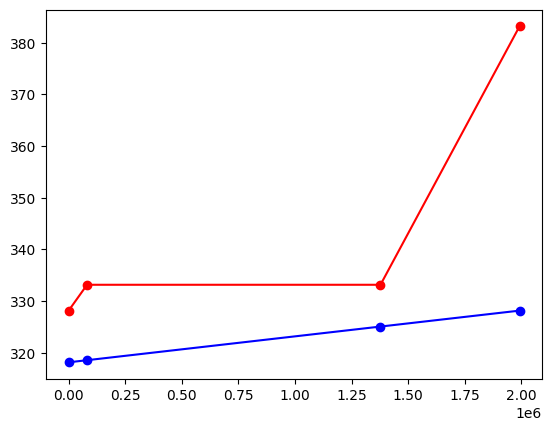

In [6]:
from matplotlib import pyplot as plt


heat, T_hot, T_cold, heat_per_section, td_log_per_section = heatex.calc_sections()

fig, ax = plt.subplots(1)

ax.plot(heat, T_hot, "o-", color="red")
ax.plot(heat, T_cold, "o-", color="blue")

- pinches are T_hot - T_cold

In [7]:
T_hot - T_cold

array([10.        , 14.59169089,  8.08331341, 55.        ])


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 5.58e+00   | 58 %       | 1.13e+00   | 2.35e+05   | 1.82e+04   | 0.00e+00   | 0.00e+00   
 2     | 3.16e-01   | 72 %       | 3.28e-02   | 8.92e+03   | 2.14e+02   | 0.00e+00   | 0.00e+00   
 3     | 6.28e-04   | 100 %      | 2.86e-05   | 1.09e+01   | 7.03e-01   | 0.00e+00   | 0.00e+00   
 4     | 1.47e-07   | 100 %      | 2.79e-08   | 5.45e-03   | 4.56e-04   | 0.00e+00   | 0.00e+00   
 5     | 1.40e-09   | 100 %      | 7.77e-12   | 1.56e-06   | 1.29e-07   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.05 s, Iterations per second: 100.22


array([ 4.59722394,  9.2137448 ,  2.5       , 49.59722394])

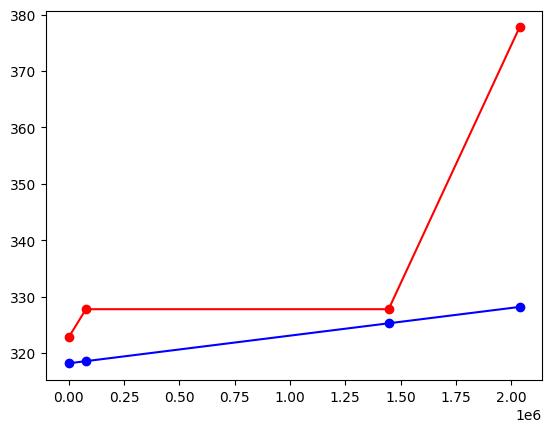

In [8]:
c1.set_attr(T_dew=None)
heatex.set_attr(td_pinch=2.5)
nw.solve("design")

heat, T_hot, T_cold, heat_per_section, td_log_per_section = heatex.calc_sections()

fig, ax = plt.subplots(1)

ax.plot(heat, T_hot, "o-", color="red")
ax.plot(heat, T_cold, "o-", color="blue")

T_hot - T_cold

- kA references the terminal temperatures and calculates td_log based on those
- UA references the terminal temperatures of each section and sums the UA of
  all sections to total UA

In [9]:
heatex.kA.val, heatex.UA.val

(107696.44791648, 315051.56453399634)

Fix UA for pinch calculation is also possible

In [10]:
heatex.set_attr(td_pinch=None, UA=350e3)
nw.solve("design")
nw.save("design.json")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 3.49e+04   | 16 %       | 9.91e-02   | 2.02e+04   | 1.67e+03   | 0.00e+00   | 0.00e+00   
 2     | 5.42e+03   | 25 %       | 1.14e-02   | 2.34e+03   | 1.90e+02   | 0.00e+00   | 0.00e+00   
 3     | 9.95e+01   | 44 %       | 2.18e-04   | 4.45e+01   | 3.63e+00   | 0.00e+00   | 0.00e+00   
 4     | 4.22e-02   | 81 %       | 9.43e-08   | 1.89e-02   | 1.56e-03   | 0.00e+00   | 0.00e+00   
 5     | 5.97e-06   | 100 %      | 1.34e-11   | 2.66e-06   | 2.32e-07   | 0.00e+00   | 0.00e+00   
 6     | 7.93e-07   | 100 %      | 1.67e-12   | 3.56e-07   | 2.82e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 6, Calculation time: 0.06 s, Iterations per second: 102.78


array([ 4.15215426,  8.77051812,  2.04118551, 49.15215426])

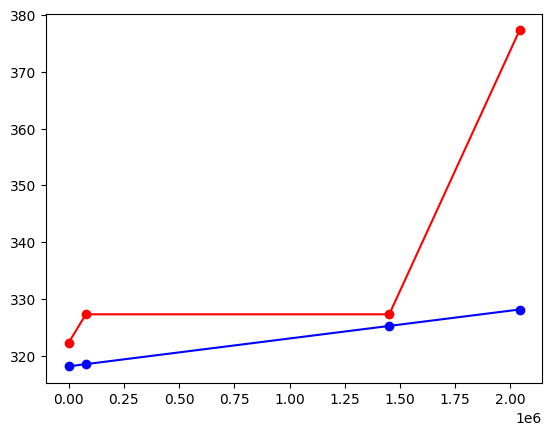

In [11]:
heat, T_hot, T_cold, heat_per_section, td_log_per_section = heatex.calc_sections()

fig, ax = plt.subplots(1)

ax.plot(heat, T_hot, "o-", color="red")
ax.plot(heat, T_cold, "o-", color="blue")

T_hot - T_cold

We can adapt UA in offdesign with the UA_cecchinato modification


$$
            f_\text{UA}=\frac{
                1 + \frac{\alpha_\text{sf}}{\alpha_\text{r}}
                \cdot\frac{A_\text{sf}}{A_\text{r}}
            }{
                \frac{\dot m_\text{sf}}{\dot m_\text{sf,ref}}^{-Re_\text{sf}} +
                \frac{\alpha_\text{sf}}{\alpha_\text{r}}
                \cdot\frac{A_\text{sf}}{A_\text{r}}
                \cdot\frac{\dot m_\text{r}}{\dot m_\text{r,ref}}^{-Re_\text{r}}
            }
$$


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.70e-06   | 100 %      | 3.94e-12   | 7.61e-07   | 6.43e-08   | 0.00e+00   | 0.00e+00   
 2     | 3.25e-06   | 100 %      | 7.17e-12   | 1.46e-06   | 1.22e-07   | 0.00e+00   | 0.00e+00   
 3     | 6.14e-07   | 100 %      | 1.39e-12   | 2.76e-07   | 2.32e-08   | 0.00e+00   | 0.00e+00   
 4     | 1.39e-07   | 100 %      | 2.59e-15   | 6.54e-08   | 2.34e-09   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.04 s, Iterations per second: 102.85

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.27e+05   | 9 %        | 2.90e+00   | 6.50e+03   | 5.40e+02   | 0.00e+00   | 0.00e+00   
 2     | 6.61e+03   | 24 %    

 3     | 1.55e+02   | 42 %       | 3.23e-04   | 7.01e+01   | 5.74e+00   | 0.00e+00   | 0.00e+00   
 4     | 6.89e-02   | 79 %       | 1.44e-07   | 3.12e-02   | 2.52e-03   | 0.00e+00   | 0.00e+00   
 5     | 3.38e-05   | 100 %      | 7.16e-11   | 1.52e-05   | 1.27e-06   | 0.00e+00   | 0.00e+00   
 6     | 2.51e-06   | 100 %      | 5.44e-12   | 1.13e-06   | 9.46e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 6, Calculation time: 0.06 s, Iterations per second: 103.23

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.27e+05   | 9 %        | 2.90e+00   | 7.06e+03   | 5.88e+02   | 0.00e+00   | 0.00e+00   
 2     | 7.66e+03   | 23 %       | 1.42e-02   | 3.28e+03   | 2.73e+02   | 0.00e+00   | 0.00e+00   
 3     | 2.17e+02   | 40 %       | 4.25e-04   | 9.85e+01   | 8.07e+00   | 0.00e+00   | 0.00e+00   
 4     | 2.66e-01   | 73 %     

 1     | 1.28e+05   | 9 %        | 2.90e+00   | 7.75e+03   | 6.46e+02   | 0.00e+00   | 0.00e+00   
 2     | 8.99e+03   | 22 %       | 1.54e-02   | 3.81e+03   | 3.18e+02   | 0.00e+00   | 0.00e+00   
 3     | 3.11e+02   | 38 %       | 5.68e-04   | 1.41e+02   | 1.16e+01   | 0.00e+00   | 0.00e+00   
 4     | 3.22e-01   | 72 %       | 5.99e-07   | 1.47e-01   | 1.20e-02   | 0.00e+00   | 0.00e+00   
 5     | 1.14e-04   | 100 %      | 2.21e-10   | 5.20e-05   | 4.40e-06   | 0.00e+00   | 0.00e+00   
 6     | 3.10e-07   | 100 %      | 4.00e-13   | 1.42e-07   | 1.07e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 6, Calculation time: 0.06 s, Iterations per second: 102.60

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.28e+05   | 9 %        | 2.90e+00   | 8.59e+03   | 7.17e+02   | 0.00e+00   | 0.00e+00   


 2     | 1.07e+04   | 21 %       | 1.67e-02   | 4.47e+03   | 3.73e+02   | 0.00e+00   | 0.00e+00   
 3     | 4.59e+02   | 37 %       | 7.81e-04   | 2.10e+02   | 1.72e+01   | 0.00e+00   | 0.00e+00   
 4     | 9.56e-01   | 66 %       | 1.62e-06   | 4.38e-01   | 3.60e-02   | 0.00e+00   | 0.00e+00   
 5     | 3.10e-05   | 100 %      | 6.81e-11   | 1.39e-05   | 1.46e-06   | 0.00e+00   | 0.00e+00   
 6     | 5.74e-07   | 100 %      | 8.74e-13   | 2.64e-07   | 2.08e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 6, Calculation time: 0.06 s, Iterations per second: 101.73

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.29e+05   | 9 %        | 2.90e+00   | 9.67e+03   | 8.07e+02   | 0.00e+00   | 0.00e+00   
 2     | 1.30e+04   | 20 %       | 1.83e-02   | 5.30e+03   | 4.43e+02   | 0.00e+00   | 0.00e+00   
 3     | 7.02e+02   | 35 %     

 6     | 1.69e-07   | 100 %      | 3.05e-13   | 7.73e-08   | 6.97e-09   | 0.00e+00   | 0.00e+00   
 7     | 4.44e-07   | 100 %      | 7.73e-13   | 2.04e-07   | 1.80e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 7, Calculation time: 0.07 s, Iterations per second: 105.01

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.30e+05   | 9 %        | 2.90e+00   | 1.28e+04   | 1.07e+03   | 0.00e+00   | 0.00e+00   
 2     | 2.04e+04   | 18 %       | 2.19e-02   | 7.64e+03   | 6.40e+02   | 0.00e+00   | 0.00e+00   
 3     | 1.87e+03   | 30 %       | 2.42e-03   | 8.48e+02   | 7.04e+01   | 0.00e+00   | 0.00e+00   


 4     | 1.89e+01   | 52 %       | 2.49e-05   | 8.76e+00   | 7.24e-01   | 0.00e+00   | 0.00e+00   
 5     | 6.43e-04   | 100 %      | 4.46e-10   | 2.97e-04   | 2.36e-05   | 0.00e+00   | 0.00e+00   
 6     | 2.25e-07   | 100 %      | 2.09e-13   | 1.04e-07   | 8.83e-09   | 0.00e+00   | 0.00e+00   
Total iterations: 6, Calculation time: 0.06 s, Iterations per second: 103.17

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.31e+05   | 9 %        | 2.90e+00   | 1.53e+04   | 1.28e+03   | 0.00e+00   | 0.00e+00   
 2     | 2.70e+04   | 17 %       | 2.37e-02   | 9.23e+03   | 7.74e+02   | 0.00e+00   | 0.00e+00   
 3     | 3.36e+03   | 27 %       | 3.84e-03   | 1.50e+03   | 1.25e+02   | 0.00e+00   | 0.00e+00   
 4     | 6.22e+01   | 46 %       | 7.36e-05   | 2.88e+01   | 2.39e+00   | 0.00e+00   | 0.00e+00   
 5     | 2.90e-02   | 83 %     

 6     | 1.79e-05   | 100 %      | 1.48e-11   | 8.32e-06   | 6.27e-07   | 0.00e+00   | 0.00e+00   
 7     | 7.10e-07   | 100 %      | 8.06e-13   | 3.27e-07   | 2.88e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 7, Calculation time: 0.07 s, Iterations per second: 98.56

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.33e+05   | 9 %        | 2.89e+00   | 2.37e+04   | 1.99e+03   | 0.00e+00   | 0.00e+00   
 2     | 5.94e+04   | 13 %       | 2.45e-02   | 1.24e+04   | 1.04e+03   | 0.00e+00   | 0.00e+00   
 3     | 1.54e+04   | 20 %       | 1.13e-02   | 5.72e+03   | 4.81e+02   | 0.00e+00   | 0.00e+00   
 4     | 1.45e+03   | 31 %       | 1.29e-03   | 6.53e+02   | 5.46e+01   | 0.00e+00   | 0.00e+00   
 5     | 1.48e+01   | 53 %       | 1.34e-05   | 6.81e+00   | 5.68e-01   | 0.00e+00   | 0.00e+00   


 6     | 3.31e-03   | 94 %       | 3.01e-09   | 1.52e-03   | 1.27e-04   | 0.00e+00   | 0.00e+00   
 7     | 6.13e-07   | 100 %      | 6.12e-13   | 2.82e-07   | 2.41e-08   | 0.00e+00   | 0.00e+00   
 8     | 2.12e-06   | 100 %      | 1.99e-12   | 9.77e-07   | 8.32e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 8, Calculation time: 0.08 s, Iterations per second: 106.28


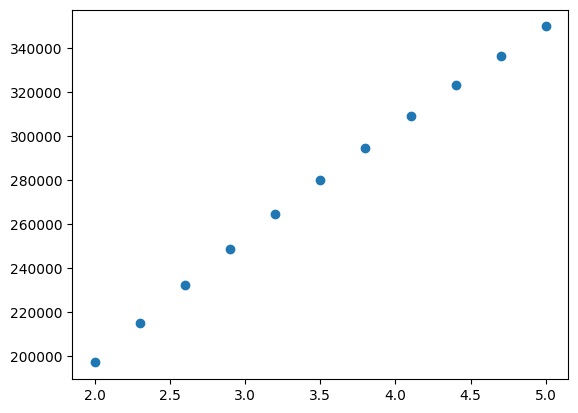

In [12]:
import numpy as np


heatex.set_attr(UA=None, alpha_ratio=1, area_ratio=1, refrigerant_index=0, re_exp_sf=0.55, re_exp_r=0.7)

m_range = np.linspace(5, 2, 11)
UA_offdesign = []
for m in m_range:
    c1.set_attr(m=m)
    nw.solve("offdesign", design_path="design.json")
    UA_offdesign.append(heatex.UA.val)


fig, ax = plt.subplots(1)

ax.scatter(m_range, UA_offdesign)

## SectionedHeatExchanger

Workflow

1. One one side:
   1. Calculate the enthalpy (linearly spaced) at $N+1$ steps (numpy linspace)
      ($N$: number sections) steps $h_i=h_\text{in} + \frac{h_\text{out} - h_\text{in}}{N} \cdot i$
   2. Assign pressure for each step (numpy linspace) $p_i=h_\text{in} + \frac{p_\text{out} - p_\text{in}}{N} \cdot i$
2. Calculate internal temperatures 
   1. Calculate enthalpies at each step
   $h_i = h_\text{in} + \frac{\dot Q_i}{\dot m}$, $h_i = h_\text{out} - \frac{\dot Q_i}{\dot m}$
   1. Calculate temperature at each step $T_i=T(p_i, h_i)$ 
   2. Calculate temperature difference at each step $\Delta T_i=T_{\text{hot,}i} - T_{\text{cold,}i}$
3. For UA only:
   1. Calculate logarithmic temperature difference per section between adjacent steps $\Delta T_{\text{log,}k}=\frac{\Delta T_i - \Delta T_{i+1}}{\ln\frac{\Delta T_i}{\Delta T_{i+1}}}$
   2. Calculate UA per section $UA_k=\frac{\dot Q_k}{\Delta T_{\text{log,}k}}$
   3. Sum UA for overall $UA = \sum UA_k$

In [13]:
from tespy.components import SectionedHeatExchanger

In [14]:
nw = Network()
nw.units.set_defaults(
    temperature="°C",
    pressure="bar"
)

In [15]:
so1 = Source("source 1")
so2 = Source("source 2")

si1 = Sink("sink 1")
si2 = Sink("sink 2")

heatex = SectionedHeatExchanger("heatexchanger")

c1 = Connection(so1, "out1", heatex, "in1", label="c1")
c2 = Connection(heatex, "out1", si1, "in1", label="c2")
d1 = Connection(so2, "out1", heatex, "in2", label="d1")
d2 = Connection(heatex, "out2", si2, "in1", label="d2")

nw.add_conns(c1, c2, d1, d2)

Impose pressure difference and note drift of T in QT diagram

In [16]:
c1.set_attr(fluid={"R290": 1}, td_dew=50, T_dew=60, m=5)
c2.set_attr(td_bubble=5)
d1.set_attr(fluid={"water": 1}, p=1, T=45)
d2.set_attr(T=55)

heatex.set_attr(dp1=1, dp2=0)

nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.97e+06   | 0 %        | 4.71e+01   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 2     | 4.57e-06   | 100 %      | 1.09e-10   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 3     | 0.00e+00   | 100 %      | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 4     | 4.66e-10   | 100 %      | 1.11e-14   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.00 s, Iterations per second: 3366.89


In [17]:
heatex.UA.val

173083.64661125193

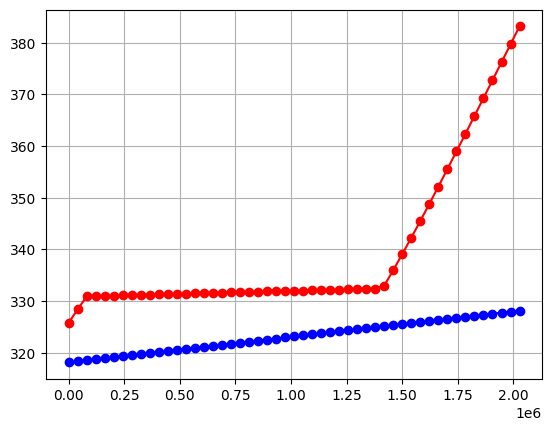

In [18]:
heat, T_hot, T_cold, heat_per_section, td_log_per_section = heatex.calc_sections()

fig, ax = plt.subplots(1)

ax.plot(heat, T_hot, "o-", color="red")
ax.plot(heat, T_cold, "o-", color="blue")

ax.grid()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 2.33e-10   | 100 %      | 5.57e-15   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 2     | 4.66e-10   | 100 %      | 1.11e-14   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 3     | 2.33e-10   | 100 %      | 5.57e-15   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
 4     | 0.00e+00   | 100 %      | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   | 0.00e+00   
Total iterations: 4, Calculation time: 0.00 s, Iterations per second: 2842.15


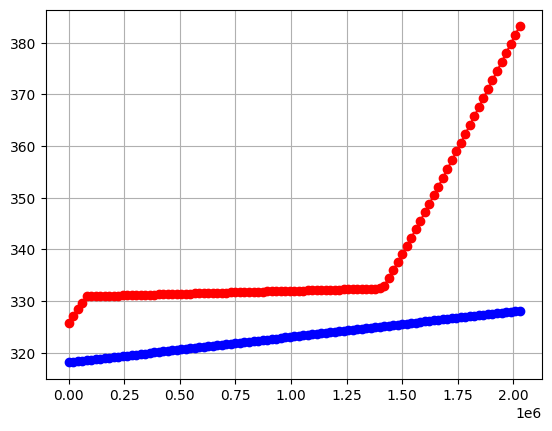

In [19]:
heatex.set_attr(num_sections=100)
nw.solve("design")

heat, T_hot, T_cold, heat_per_section, td_log_per_section = heatex.calc_sections()

fig, ax = plt.subplots(1)

ax.plot(heat, T_hot, "o-", color="red")
ax.plot(heat, T_cold, "o-", color="blue")

ax.grid()

setting UA/td_pinch is significantly slower

In [20]:
c1.set_attr(T_dew=None)
heatex.set_attr(td_pinch=2.5)
nw.solve("design")


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------


 1     | 4.88e+00   | 59 %       | 1.06e+00   | 2.10e+05   | 1.67e+04   | 0.00e+00   | 0.00e+00   


 2     | 3.93e-01   | 71 %       | 5.70e-02   | 1.37e+04   | 6.58e+02   | 0.00e+00   | 0.00e+00   


 3     | 1.51e-03   | 98 %       | 8.88e-05   | 3.66e+01   | 6.36e-01   | 0.00e+00   | 0.00e+00   


 4     | 6.88e-08   | 100 %      | 2.17e-09   | 2.92e-04   | 1.60e-05   | 0.00e+00   | 0.00e+00   


 5     | 9.31e-10   | 100 %      | 2.22e-12   | 3.87e-07   | 3.47e-08   | 0.00e+00   | 0.00e+00   
Total iterations: 5, Calculation time: 0.97 s, Iterations per second: 5.14
